<a href="https://colab.research.google.com/github/Sanjeev2697UCSD/CDM_Dykstra/blob/main/LASSO_using_Co_ordinate_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the required library files



In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn.datasets as dt
import cvxpy as cp
import time

**Definition of Co-ordinate Descent Algorithm for LASSO:**

The Algorithm for implementation of LASSO is taken from the [lecture notes](https://www.cs.cmu.edu/~ggordon/10725-F12/slides/25-coord-desc.pdf) of Prof. Ryan Tibshirani.

**About Co-ordinate Descent Algorithm:**


> Let us assume that we are given an unconstrained convex diffrentiable function which needs to be minimized. The true definition of the minimizer is that the partial derivative of the function along each dimension at minimizer is zero. We leverage this information where we try to perform minimization across each dimension. This is the core idea behind Co-ordinate Descent Algorithm.

**Co-ordinate Descent Algorithm for LASSO:**

One can perform Co-ordinate descent in blocks (two or three columns / dimensions simultaneously) which are linearly independent of each other. Here, in this implementation, we take an iterative approach where each iteration corresponds to one dimension and we cycle through the dimensions for a few number of iterations. The order of time complexity here is O(mn) where n is the number of dimensions and m is the number of iterations the algorithm is carried out.

**Equation for Co-ordinate descent update in the LASSO problem:**

The primal problem for LASSO is minimize the following convex problem

$1/2 * ||y - X*beta|| + lambda * ||beta||_1$

over all $beta \; \varepsilon \; R^p$ where

1.   $beta$ is the feature vector belongs to $R^{p*1}$
2.   $y$ is the observation vector belongs to $R^{N*1}$
3.   $X$ is the transformation matrix or predictor matrix of dimension $R^{N*p}$
4.   $lambda$ is the hyperparameter or regularization parameter which scales the penalty in case of error to the objective function.

The update for a beta is given by:

 
  $beta_i = (X_i^T(y - X_{-i}*beta_{-i}))/(X_i^T*X_i) $

 where

*   $i$ is the feature which is under update.

As we see here, the penalty function here is the $||beta||$ which is not diffrentiable at $beta \; = \; 0$. We take into account of the sub-differential at $beta \; = \; 0$ which states that the derivative of $||beta||$ over $beta$ can take a value between $[-1, 1]$. 














In [ ]:
def coordinate_descent_function(X,y,lambda1, MAX_ITERATIONS):
  # initialize Beta vector = 0
  N = np.size(y)
  p = np.shape(X)[1]
  y = y.reshape(N, 1)
  beta = np.zeros([p,1])
  num_iterations = 0;
  while(num_iterations <= MAX_ITERATIONS):
    for i in range(p):
      idx_out_columns = [i]
      idx_in_columns = [j for j in range(p) if j not in idx_out_columns]
      X_r = X[:,idx_in_columns]
      beta_r = beta[idx_in_columns,]
      residual = y - np.matmul(X_r, beta_r)[:,]

      # Computing the inner product to figure out how much magnitude of correlation this dimension holds
      # ols_beta = np.matmul(np.transpose(residual) , X[:,idx_out_columns])
      ols_beta = (X[:,idx_out_columns].T @ residual)[0,0]

      normalizer = (X[:,idx_out_columns].T @ X[:,idx_out_columns])[0,0]
      ols_beta = ols_beta/normalizer
      lambda2 = lambda1/normalizer

      # Update beta[i] via soft-thresholding
      beta[i] = compute_soft_thresholding(ols_beta, lambda2)
    
    num_iterations = num_iterations + 1
  return beta


def compute_soft_thresholding(ols_beta, lambda1):
  if ols_beta > lambda1:
    return ols_beta - (lambda1)
  elif ols_beta < -1*lambda1:
    return ols_beta + (lambda1)
  else:
    return 0

In [ ]:
def lasso_dual(X,y,lambda1, MAX_ITERATIONS):
  # Implementing the CVX version of the LASSO dual problem:
  # X -> N xp
  # y -> N x1
  # u[i,:] -> 1xN where i is from 0 to 2p. Therefore, there are 2p + 1 rows
  # u -> 2pxN . Similar for z

  N = np.size(y)           # num_observations      
  # p = N
  p = np.size(X,1)

  y = y.reshape(len(y),1)
  print(np.shape(X))
  print(np.shape(y))

  # u_prev = y;
  # z_prev = np.zeros((2*p,N));
  u = np.zeros((2*p + 1,N));
  u[2*p,:] = y.T;
  z = np.zeros((2*p + 1,N));
  iteration = 0;
  while iteration <= MAX_ITERATIONS:
    u[0,:] =  u[2*p,:];
    for i in range(1,2*p+1):
      # u[i] = cvx_solver_dual(u[i-1] + z_prev[i], X[i,].T, lambda1)
      u[i,:] = cvx_solver_dual((u[i-1,:] + z[i,:]).T, X[:,i%p], lambda1, i,p, N)
      z[i,:] = u[i-1,:] + z[i,:] - u[i,:]
    # u_prev = u
    # z_prev = z
    iteration = iteration + 1

  return u[2*p,:]

In [ ]:
def cvx_solver_dual(y, X, lambda1, i, p,N):
  # Implementing the CVX version of the same problem
  theta = cp.Variable((N,1))
  y = y.reshape(len(y),1)
  X = X.reshape(len(X),1)
  # objective = cp.Minimize(cp.norm(y-theta,2)**2)
  objective = cp.Minimize(cp.sum_squares(y-theta))
  # constraints = [0 <= beta_pcvx, beta_pcvx <= 1]
  # constraints = [constraint * x <= lambda1, -1 * lambda1 <= constraint *x]
  if i <= p:
    constraints = [X.T @ theta <= lambda1]
  else:
    constraints = [-1*lambda1 <= X.T @ theta]
  prob = cp.Problem(objective, constraints)
  result = prob.solve()

  return (theta.value).T

In [ ]:
def cvx_optimizer(X, y, lambda1):
  # Implementing the CVX version of the same problem
  p = np.size(X,1)
  beta_pcvx = cp.Variable(p)
  objective = cp.Minimize(cp.sum_squares(X*beta_pcvx - y) + lambda1*cp.norm1(beta_pcvx))
  # constraints = [0 <= beta_pcvx, beta_pcvx <= 1]
  constraints = []
  prob = cp.Problem(objective, constraints)
  result = prob.solve()

  return beta_pcvx.value

In [ ]:
def compute_loss_function(beta, beta_predicted):
  beta = beta.reshape(len(beta),1)
  beta_predicted = beta_predicted.reshape(len(beta_predicted),1)
  return (beta - beta_predicted).T @ (beta - beta_predicted)

In [ ]:
# Generation of dataset (synthetic dataset)
# Normal distribution of random variables:

def generate_dataset(dataset_type, *args):
  if dataset_type == 0:
    # Generate a dataset from sklearn dataset
    dataset = dt.load_diabetes()
    X,y = dataset.data, dataset.target
    return X,y
  else:
    N = args[0]     # Number of observations
    p = args[1]     # Number of features
    sigma = args[2] # The Variance of the samples in the transformation matrix
    mu = args[3]    # The mean of the samples in the transformation matrix
    s = args[4]  # Probability of generating a 1 in the beta vector

    X = sigma*np.random.randn(N,p) + mu
    
    y, beta = generate_beta(X,s)

    return X,y,beta

def rand_bin_array(K, N):
    arr = np.zeros(N)
    arr[:K]  = 1 # 111000000
    np.random.shuffle(arr) # 001100100
    return arr

In [ ]:
# Generation of a random feature vector beta in presence of transformation matrix X

def generate_beta(X, s):
  N = np.shape(X)[0]
  p = np.shape(X)[1]
  random_vector = np.random.rand(p,1)*10   # Multiplication by sigma
  beta = rand_bin_array(s,p)
  beta = np.multiply(random_vector.T, beta).T

  y = np.matmul(X, beta)

  beta = beta.reshape(p,)

  return y,beta


In [ ]:
# Dataset generator and Tester code (sample):

DATASET_TYPE = 1   # 1 for synthetic dataset and 0 for dataset from sklearn
NOISE_INCLUDE = 1  
N = 6             # num_observations
p = 10              # num_features

# Synthetic dataset related variables

sigma = 10
mu = 0
s = 5

if DATASET_TYPE:
  X,y,beta = generate_dataset(DATASET_TYPE, N, p, sigma, mu, s)
else:
  X,y = generate_dataset(0,)

if NOISE_INCLUDE:
  # Adding noise to the output signal
  y = y + np.random.randn(N, 1)

In [ ]:

# Choosing lambda w.r.t noise variance
lambda1 = 1
MAX_ITERATIONS  = 70000

# Co-ordinate descent:
beta_predicted_cdm = coordinate_descent_function(X,y, lambda1, MAX_ITERATIONS)
objective_function_cdm = 0.5 * ((y - X@beta_predicted_cdm).T@(y - X@beta_predicted_cdm)) + lambda1 * np.sum(abs(beta_predicted_cdm))

# CVX solver:
beta_cvx_optimizer = cvx_optimizer(X,y[:,0], lambda1)


# Lasso dual:
theta_predicted_lasso = lasso_dual(X,y,lambda1, 3000)
theta_predicted_lasso = theta_predicted_lasso.reshape(len(theta_predicted_lasso),1)
objective_function_lasso = 0.5*((y.T@y) - ((y - theta_predicted_lasso).T@(y - theta_predicted_lasso)))

# print(y - X @ beta_predicted_cdm)
# print("2.")
# print(theta_predicted_lasso)

In [ ]:
print(np.shape(theta_predicted_lasso))

(6, 1)


In [ ]:
print("LASSO minimizer (primal)")
print(objective_function_cdm)
print("LASSO minimizer (dual)")
print(objective_function_lasso)

LASSO minimizer (primal)
[[106.8427989]]
LASSO minimizer (dual)
[[104.84712392]]


Comparison between primal and dual solutions.

In [ ]:
print('Dual')
print(theta_predicted_lasso)
print('primal')
print(y - X@beta_predicted_cdm)
x2 = y - X@beta_predicted_cdm


Dual
[[ 0.0122329 ]
 [ 0.02528404]
 [ 0.00988566]
 [-0.0265992 ]
 [ 0.05632944]
 [ 0.05811656]]
primal
[[ 0.01129794]
 [ 0.01774957]
 [ 0.0136876 ]
 [-0.03132718]
 [ 0.05498977]
 [ 0.05292471]]


In [ ]:
# Post-processing analysis of Co-ordinate Descent Method:

print('Predicted')
print(beta_predicted_cdm)

print('Actual')
print(beta)

print('CVX solver')
print(beta_cvx_optimizer)

error = compute_loss_function(beta, beta_predicted_cdm)
print('Error')
print(error)

beta_predicted_cdm_norm = beta_predicted_cdm / np.max(beta_predicted_cdm)
num_zeros = len([0 for i in beta_predicted_cdm_norm if i < 0.01])
print(beta_predicted_cdm)


print('Number of non-zero elements: ')
print(p - num_zeros)

print('Using inverse')
print(np.linalg.pinv(X)@y)

Predicted
[[-0.01322907]
 [-0.03864653]
 [-0.02381943]
 [-0.00846776]
 [ 0.02655011]
 [ 0.00898827]
 [-0.05085125]
 [ 5.08202957]
 [ 0.12882092]
 [-0.01191998]]
Actual
[0.         0.         0.         0.         0.         0.
 0.         5.09214451 0.1250065  0.        ]
CVX solver
[-0.01374767 -0.03887778 -0.02464254 -0.00877668  0.02679681  0.00920137
 -0.05112626  5.08256377  0.12960954 -0.01246381]
Error
[[0.00593813]]
[[-0.01322907]
 [-0.03864653]
 [-0.02381943]
 [-0.00846776]
 [ 0.02655011]
 [ 0.00898827]
 [-0.05085125]
 [ 5.08202957]
 [ 0.12882092]
 [-0.01191998]]
Number of non-zero elements: 
2
Using inverse
[[-0.01426627]
 [-0.03910902]
 [-0.02546565]
 [-0.0090856 ]
 [ 0.0270435 ]
 [ 0.00941447]
 [-0.05140128]
 [ 5.08309797]
 [ 0.13039816]
 [-0.01300765]]


In [ ]:
# print(y - X @ beta_predicted_cdm)
# print()
print(theta_predicted_lasso - (y - X @ beta_predicted_cdm))

[[ 0.1453006 ]
 [ 0.57147267]
 [-0.65302984]
 [ 0.29605642]
 [-0.71905269]
 [-0.40741289]
 [ 0.09133391]
 [ 0.00320086]
 [ 0.02431331]
 [ 0.29373709]]


In [ ]:
objective_function_lasso = 0.5*((y.T@y) - ((y - theta_predicted_lasso).T@(y - theta_predicted_lasso)))
objective_function_cdm = 0.5 * ((y - X@beta_predicted_cdm).T@(y - X@beta_predicted_cdm)) + lambda1 * np.sum(abs(beta_predicted_cdm))
print(objective_function_cdm)
print(objective_function_lasso)

[[157.95575018]]
[[-209.02831186]]


In [ ]:
print("Feature vector (original)")
print(beta.T)
print("Feature vector using LASSO primal")
print(beta_predicted_cdm.T)
print("Feature vector using CVX solver")
print(beta_cvx_optimizer.value.T)

Feature vector (original)
[[0. 0. 0. 0. 1. 0. 1. 0.]]
Feature vector using LASSO primal
[[-6.85981823e-02 -9.74432165e-04  1.03074699e-01 -5.62619872e-02
   1.06126502e+00 -1.15658162e-01  1.05838785e+00 -5.20130286e-02]]
Feature vector using CVX solver
[-6.28153232e-02 -4.92024168e-19  9.45267978e-02 -4.91095158e-02
  1.05634515e+00 -1.02967223e-01  1.05297329e+00 -4.37645095e-02]


In [ ]:
# Variation parameter : N (num_observations)
# Here num_features is assumed to be 1000 (Inspired from Riboflavin dataset). The Number of observations is varied from 70 to 2000 in steps of 10.
# The number of non-zero elements is fixed at 40 out 1000 features.

DATASET_TYPE = 1   # 1 for synthetic dataset and 0 for dataset from sklearn
NOISE_INCLUDE = 1  

num_observations_min = 20;
num_observations_max = 200;
step_size = 10;

N = np.arange(num_observations_min, num_observations_max, step_size)        # num_observations
p = 100                                                                      # num_features

# Synthetic dataset related variables

sigma = 10         # Variance of the transformation matrix (X)
mu = 0             # Mean of the transformation matrix (X)
# s = 4              # number of non-zero elements
num_passes = 1

s_min = 4;
s_max = 40;
s_step = 2;

s = np.arange(s_min, s_max, s_step)


iteration  = 0

# Initialization:
beta = np.zeros([p, len(N)])
beta_predicted_cdm = np.zeros([p, len(N)])
beta_cvx_optimizer = np.zeros([p,len(N)])
error_cdm = np.zeros([len(N)])
objective_function_cdm = np.zeros([len(N)])
time_interval_cdm = np.zeros([len(N)])
time_interval_cvx = np.zeros([len(N)])
support_recovery = np.zeros([p, len(N)])
num_non_zeros_predicted = np.zeros(len(N))

for i in N:
  GENERATE_ALL = True
  for n in range(num_passes):
    if DATASET_TYPE and GENERATE_ALL:
      X,y,beta[:,iteration] = generate_dataset(DATASET_TYPE, i, p, sigma, mu, s[iteration])
      GENERATE_ALL = False
    elif DATASET_TYPE and ~GENERATE_ALL:
        y, beta[:,iteration] = generate_beta(X,s[iteration])

    if NOISE_INCLUDE:
      # Adding noise to the output signal
      y = y + np.random.randn(i, 1)

    # Choosing lambda w.r.t noise variance
    lambda1 = 2
    MAX_ITERATIONS  = 70000


    # Co-ordinate descent:
    time_start_cdm = time.time()
    beta_predicted_cdm[:,iteration] = coordinate_descent_function(X,y, lambda1, MAX_ITERATIONS).reshape(p,)
    time_interval_cdm[iteration] = time.time() - time_start_cdm

    objective_function_cdm[iteration] = 0.5 * ((y - X@beta_predicted_cdm[:,iteration].reshape(p, 1)).T@(y - X@beta_predicted_cdm[:,iteration].reshape(p, 1))) + lambda1 * np.sum(abs(beta_predicted_cdm[:,iteration].reshape(p, 1)))

    # CVX solver:
    # if i > 14:
    #   time_start_cvx = time.time()
    #   beta_cvx_optimizer[:,iteration] = cvx_optimizer(X,y[:,0], lambda1).T
    #   time_interval_cvx[iteration] = time.time() - time_start_cvx

    # Post-processing:
    
    # L2 loss:
    error_cdm[iteration] = error_cdm[iteration] + compute_loss_function(beta[:, iteration], beta_predicted_cdm[:, iteration])
    # Support recovery:

    for j in range(0, p):
      if beta[j,iteration] == 0:
        if abs(beta_predicted_cdm[j, iteration]) < 0.4:
          support_recovery[j, iteration] = support_recovery[j, iteration] + 1


  support_recovery[:, iteration] = support_recovery[:, iteration] / num_passes
  num_non_zeros_predicted[iteration] = np.sum(support_recovery[:,iteration])

  error_cdm[iteration] = error_cdm[iteration] / num_passes
  iteration = iteration + 1



In [ ]:
# Saving the data obtained from running the Co-ordinate Descent Algorithm:

np.savetxt(fname="beta_predicted_cdm.csv", delimiter=",", X=beta_predicted_cdm)
np.savetxt(fname="beta_original.csv", delimiter=",", X=beta)
np.savetxt(fname="Time_Interval.csv", delimiter=",", X=time_interval_cdm)
np.savetxt(fname="support_recovery.csv", delimiter=",", X=support_recovery)
np.savetxt(fname="error_cdm.csv", delimiter=",", X=error_cdm)

In [ ]:
# Variation parameter : N (num_observations)
# Here num_features is assumed to be 1000 (Inspired from Riboflavin dataset). The Number of observations is varied from 70 to 2000 in steps of 10.
# The number of non-zero elements is fixed at 40 out 1000 features.

DATASET_TYPE = 1   # 1 for synthetic dataset and 0 for dataset from sklearn
NOISE_INCLUDE = 1  

num_observations_min = 2;
num_observations_max = 24;
step_size = 2;

N = np.arange(num_observations_min, num_observations_max, step_size)        # num_observations
p = 100                                                                      # num_features

# Synthetic dataset related variables

sigma = 10         # Variance of the transformation matrix (X)
mu = 0             # Mean of the transformation matrix (X)
s = 4              # number of non-zero elements
num_passes = 1



iteration  = 0

# Initialization:
beta = np.zeros([p, len(N)])
beta_cvx_optimizer = np.zeros([p,len(N)])
time_interval_cvx = np.zeros([len(N)])
error_cvx = np.zeros([len(N)])
support_recovery_cvx = np.zeros([p, len(N)])
num_non_zeros_predicted_cvx = np.zeros(len(N))


for i in N:
  GENERATE_ALL = True
  for n in range(num_passes):
    if DATASET_TYPE and GENERATE_ALL:
      X,y,beta[:,iteration] = generate_dataset(DATASET_TYPE, i, p, sigma, mu, s)
      GENERATE_ALL = False
    elif DATASET_TYPE and ~GENERATE_ALL:
        y, beta[:,iteration] = generate_beta(X,s)

    if NOISE_INCLUDE:
      # Adding noise to the output signal
      y = y + np.random.randn(i, 1)

    # Choosing lambda w.r.t noise variance
    lambda1 = 2

    # CVX solver:
    # if i > 14:
    time_start_cvx = time.time()
    beta_cvx_optimizer[:,iteration] = cvx_optimizer(X,y[:,0], lambda1).T
    time_interval_cvx[iteration] = time.time() - time_start_cvx

      # L2 loss:
    error_cvx[iteration] = error_cvx[iteration] + compute_loss_function(beta[:, iteration], beta_cvx_optimizer[:, iteration])
    # Support recovery:

    for j in range(0, p):
      if beta[j,iteration] == 0:
        if abs(beta_cvx_optimizer[j, iteration]) < 0.4:
          support_recovery_cvx[j, iteration] = support_recovery_cvx[j, iteration] + 1


  support_recovery_cvx[:, iteration] = support_recovery_cvx[:, iteration] / num_passes
  num_non_zeros_predicted_cvx[iteration] = np.sum(support_recovery_cvx[:,iteration])

  error_cvx[iteration] = error_cvx[iteration] / num_passes
  iteration = iteration + 1


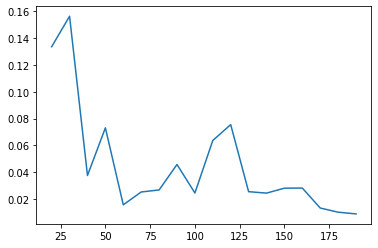

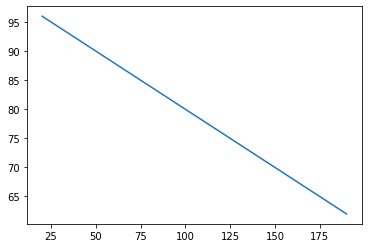

In [ ]:
#  Plotting the values obtained:
# Co-ordinate Descent Algorithm:

# N is varied from 20 to 200 in steps of 10
# L2 Loss function plot
plt.figure()
plt.plot(N,error_cdm)

# Support recovery performance
plt.figure()
plt.plot(N,num_non_zeros_predicted)

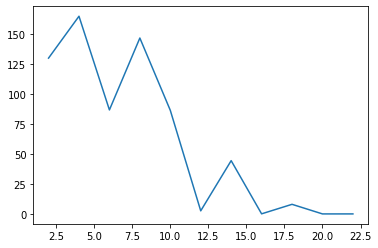

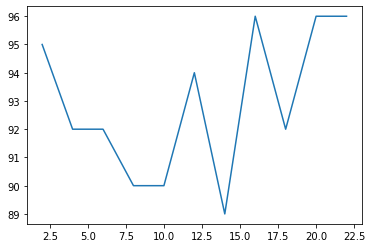

In [ ]:
#  Plotting the values obtained:
# Co-ordinate Descent Algorithm:

# N is varied from 2 to 24 in steps of 2
# L2 Loss function plot
plt.figure()
plt.plot(N,error_cdm)

# Support recovery performance
plt.figure()
plt.plot(N,num_non_zeros_predicted)

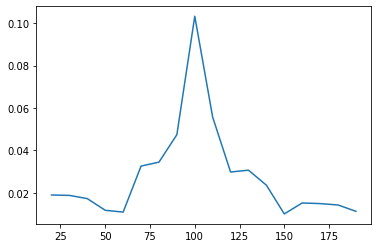

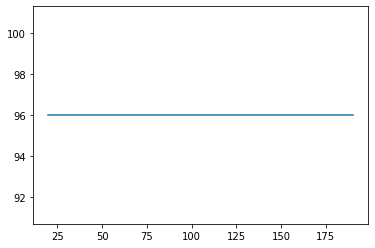

In [ ]:
#  Plotting the values obtained:
# CVX optimizer (QSQP solver):

# L2 Loss function plot
plt.figure()
plt.plot(N,error_cvx)

# Support recovery performance
plt.figure()
plt.plot(N,num_non_zeros_predicted_cvx)

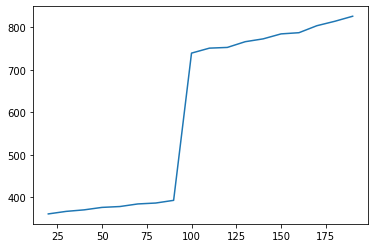

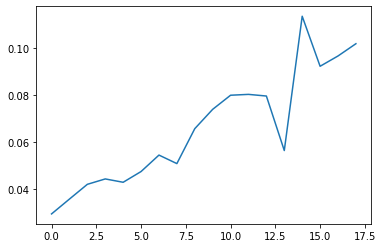

In [ ]:
# Time Interval Comparison:
# Time taken for Co-ordinate descent
plt.figure()
plt.plot(N,time_interval_cdm)
# Time taken by the CVX module
plt.figure()
plt.plot(time_interval_cvx)


In [ ]:
# Saving the data obtained from running the CVXPY module:

np.savetxt(fname="beta_cvx_optimizer.csv", delimiter=",", X=beta_cvx_optimizer)
np.savetxt(fname="beta_original_cvx.csv", delimiter=",", X=beta)
np.savetxt(fname="Time_Interval_cvx.csv", delimiter=",", X=time_interval_cvx)
np.savetxt(fname="support_recovery_cvx.csv", delimiter=",", X=support_recovery_cvx)
np.savetxt(fname="error_cvx.csv", delimiter=",", X=error_cvx)

In [ ]:
# Variation parameter: prob (sparsity)
# Sparsity of the solution is indirectly varied by changing the probability of the binary random generator (prob)

DATASET_TYPE = 1   # 1 for synthetic dataset and 0 for dataset from sklearn
NOISE_INCLUDE = 1  

num_observations_min = 5;
num_observations_max = 90;
step_size = 5;

s = np.arange(num_observations_min, num_observations_max, step_size)        # num_observations
p = 100                                                                      # num_features

# Synthetic dataset related variables

sigma = 10         # Variance of the transformation matrix (X)
mu = 0             # Mean of the transformation matrix (X)
N = 50              # number of non-zero elements
num_passes = 1

iteration  = 0

# Initialization:
beta = np.zeros([p, len(s)])
beta_predicted_cdm = np.zeros([p, len(s)])
beta_cvx_optimizer = np.zeros([p,len(s)])
error_cdm = np.zeros([len(s)])
objective_function_cdm = np.zeros([len(s)])
time_interval_cdm = np.zeros([len(s)])
time_interval_cvx = np.zeros([len(s)])
support_recovery = np.zeros([p, len(s)])
num_non_zeros_predicted = np.zeros(len(s))

for i in s:
  GENERATE_ALL = True
  for n in range(num_passes):
    if DATASET_TYPE and GENERATE_ALL:
      X,y,beta[:,iteration] = generate_dataset(DATASET_TYPE, N, p, sigma, mu, i)
      GENERATE_ALL = False
    elif DATASET_TYPE and ~GENERATE_ALL:
        y, beta[:,iteration] = generate_beta(X,i)

    if NOISE_INCLUDE:
      # Adding noise to the output signal
      y = y + np.random.randn(N, 1)

    # Choosing lambda w.r.t noise variance
    lambda1 = 2
    MAX_ITERATIONS  = 70000


    # Co-ordinate descent:
    time_start_cdm = time.time()
    beta_predicted_cdm[:,iteration] = coordinate_descent_function(X,y, lambda1, MAX_ITERATIONS).reshape(p,)
    time_interval_cdm[iteration] = time.time() - time_start_cdm

    objective_function_cdm[iteration] = 0.5 * ((y - X@beta_predicted_cdm[:,iteration].reshape(p, 1)).T@(y - X@beta_predicted_cdm[:,iteration].reshape(p, 1))) + lambda1 * np.sum(abs(beta_predicted_cdm[:,iteration].reshape(p, 1)))

    # CVX solver:
    # if i > 14:
    #   time_start_cvx = time.time()
    #   beta_cvx_optimizer[:,iteration] = cvx_optimizer(X,y[:,0], lambda1).T
    #   time_interval_cvx[iteration] = time.time() - time_start_cvx

    # Post-processing:
    
    # L2 loss:
    error_cdm[iteration] = error_cdm[iteration] + compute_loss_function(beta[:, iteration], beta_predicted_cdm[:, iteration])
    # Support recovery:

    for j in range(0, p):
      if beta[j,iteration] == 0:
        if abs(beta_predicted_cdm[j, iteration]) < 0.4:
          support_recovery[j, iteration] = support_recovery[j, iteration] + 1


  support_recovery[:, iteration] = support_recovery[:, iteration] / num_passes
  num_non_zeros_predicted[iteration] = np.sum(support_recovery[:,iteration])

  error_cdm[iteration] = error_cdm[iteration] / num_passes
  iteration = iteration + 1



In [ ]:
np.savetxt(fname="beta_predicted_cdm.csv", delimiter=",", X=beta_predicted_cdm)
np.savetxt(fname="beta_original.csv", delimiter=",", X=beta)
np.savetxt(fname="Time_Interval.csv", delimiter=",", X=time_interval_cdm)
np.savetxt(fname="support_recovery.csv", delimiter=",", X=support_recovery)
np.savetxt(fname="error_cdm.csv", delimiter=",", X=error_cdm)

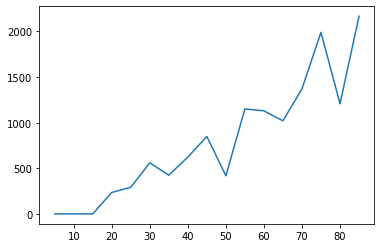

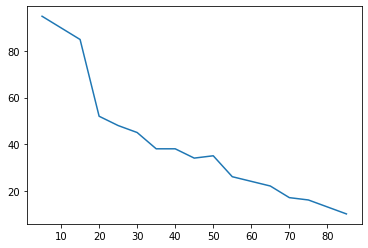

In [ ]:
#  Plotting the values obtained:

# L2 Loss function plot
plt.figure()
plt.plot(s,error_cdm)

# Support recovery performance
plt.figure()
plt.plot(s,num_non_zeros_predicted)

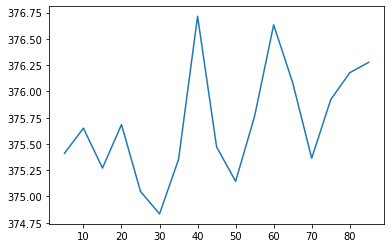

In [ ]:
plt.figure()
plt.plot(s,time_interval_cdm)

In [ ]:
# Variation parameter: p (num_features)
# Here num_observations are assumed to be 500. The num_features are varied from 70 to 5000.

# Variation parameter: prob (sparsity)
# Sparsity of the solution is indirectly varied by changing the probability of the binary random generator (prob)

DATASET_TYPE = 1   # 1 for synthetic dataset and 0 for dataset from sklearn
NOISE_INCLUDE = 1  

num_observations_min = 100;
num_observations_max = 300;
step_size = 10;

p = np.arange(num_observations_min, num_observations_max, step_size)        # num_observations
s = 8                                                                       # num_features

# Synthetic dataset related variables

sigma = 10         # Variance of the transformation matrix (X)
mu = 0             # Mean of the transformation matrix (X)
N = 24             # number of non-zero elements
num_passes = 1

iteration  = 0

# Initialization:
error_cdm = np.zeros([len(p)])
objective_function_cdm = np.zeros([len(p)])
time_interval_cdm = np.zeros([len(p)])
num_non_zeros_predicted = np.zeros(len(p))

for i in p:
  GENERATE_ALL = True
  for n in range(num_passes):
    if DATASET_TYPE and GENERATE_ALL:
      X,y,beta = generate_dataset(DATASET_TYPE, N, i, sigma, mu, s)
      GENERATE_ALL = False
    elif DATASET_TYPE and ~GENERATE_ALL:
        y, beta = generate_beta(X,s)

    if NOISE_INCLUDE:
      # Adding noise to the output signal
      y = y + np.random.randn(N, 1)

    # Choosing lambda w.r.t noise variance
    lambda1 = 2
    MAX_ITERATIONS  = 70000


    # Co-ordinate descent:
    time_start_cdm = time.time()
    beta_predicted_cdm = coordinate_descent_function(X,y, lambda1, MAX_ITERATIONS).reshape(i,)
    time_interval_cdm[iteration] = time.time() - time_start_cdm

    objective_function_cdm[iteration] = 0.5 * ((y - X@beta_predicted_cdm.reshape(i, 1)).T@(y - X@beta_predicted_cdm.reshape(i, 1))) + lambda1 * np.sum(abs(beta_predicted_cdm.reshape(i, 1)))


    # Post-processing:
    
    # L2 loss:
    error_cdm[iteration] = error_cdm[iteration] + compute_loss_function(beta, beta_predicted_cdm)
    # Support recovery:

    for j in range(0, i):
      if beta[j] == 0:
        if abs(beta_predicted_cdm[j]) < 0.4:
          num_non_zeros_predicted[iteration] = num_non_zeros_predicted[iteration] + 1


  
  error_cdm[iteration] = error_cdm[iteration] / num_passes
  iteration = iteration + 1



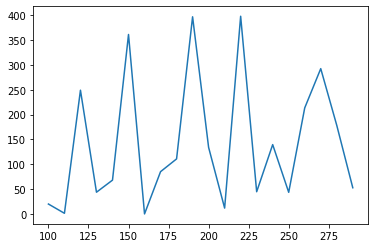

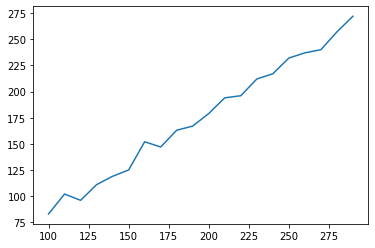

In [ ]:
#  Plotting the values obtained:

# L2 Loss function plot
plt.figure()
plt.plot(p,error_cdm)

# Support recovery performance
plt.figure()
plt.plot(p,num_non_zeros_predicted)

In [ ]:
np.savetxt(fname="Time_Interval.csv", delimiter=",", X=time_interval_cdm)
np.savetxt(fname="num_non_zeros.csv", delimiter=",", X=num_non_zeros_predicted)
np.savetxt(fname="error_cdm.csv", delimiter=",", X=error_cdm)

In [ ]:
# Variation of lambda1:

lambda1 = 1
num_iterations = 51
beta_predicted = np.zeros([num_iterations,p])
for i in range(num_iterations):
  lambda1 = lambda1 + 0.02
  beta_predicted[i,:] = coordinate_descent_function(X,y,lambda1, 100)[:,0]

beta_cvx_optimizer = cvx_optimizer(X,y[:,0])

In [ ]:
# Checking the output of the descent function with the true value
print(beta.T)
for i in range(num_iterations):
  beta_predicted[i,:] = [round(beta_predicted[i,j]) for j in range(p)]
  # print(X @ beta_predicted[i,:].T)
  print(beta_predicted[i,:])
print(beta_cvx_optimizer.value)